In [1]:
import os
import numpy as np
import torch
import cv2

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable

from torch.autograd import Variable
from torchvision.models.vgg import model_urls
import torchvision.models as models
from modeling.attention_model import Attn_Net

# All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.nn as nn 
import torch.nn.functional as F

# For all Optimization algorithms, SGD, Adam, etc.
import torch.optim as optim


# Loading and Performing transformations on dataset
import torchvision
import torchvision.transforms as transforms 
import torchvision.utils as utils
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import Sampler, WeightedRandomSampler

#Labels in CSV and Inputs in Fits in a folder
import pandas as pd
from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

#For Confusion Matrix
from sklearn.metrics import confusion_matrix

#Warnings
import warnings
warnings.simplefilter("ignore", Warning)

#Time Computation
import timeit

In [2]:
def visualize_attn_softmax(I, c, up_factor, nrow, mode):
    # image
    img = I.permute((1,2,0)).cpu().numpy()
    
    # compute the heatmap
    N,C,W,H = c.size()
    a = F.softmax(c.view(N,C,-1), dim=2).view(N,C,W,H)
    if up_factor > 1:
        a = F.interpolate(a, scale_factor=up_factor, mode=mode, align_corners=True)
    attn = utils.make_grid(a, nrow=nrow, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # print(attn.shape)
    
    # add the heatmap to the image
    vis = 0.7 * img + 0.3 * attn
    return vis

In [3]:
im_size=256
device = torch.device('cpu')
PATH = '../modeling/trained_models/attention/attn_fold1.pth'
weight = torch.load(PATH, map_location=torch.device("cpu"))
model = Attn_Net(im_size=im_size, num_classes=2).to(device)
model.load_state_dict(weight['model_state_dict'])
model.eval()

Attn_Net(
  (conv_block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv_block5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512,

In [4]:
class Data(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        hmi = Image.open(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 2]))

        if self.transform:
            image = self.transform(hmi)
            
        return (image, y_label, img_path)

    def __len__(self):
        return len(self.annotations)

In [5]:

batch_size = 3
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor()
])

data = Data(csv_file = 'plots.csv', 
                             root_dir = '/data/hmi_jpgs_512/',
                             transform = transformations)

data_loader = DataLoader(dataset=data, batch_size=batch_size,num_workers=4, pin_memory = False, shuffle=False)

In [6]:
def compute_attention(val_loader):
    images_disp= []
    with torch.no_grad():
        model.eval()
        # log scalars
        k=1
        for i, data in enumerate(val_loader):
            images_test, labels_test, img_path = data
            images_test, labels_test = images_test.to(device), labels_test.to(device)
            if i == 0: # archive images in order to save to logs
                images_disp.append(images_test[0:3,:,:,:])
            pred_test, __, __, __ = model(images_test)
            I_test = utils.make_grid(images_disp[0], nrow=3,normalize=True, scale_each=True)
            min_up_factor = 1
            vis_fun = visualize_attn_softmax
            # test data
            __, c1, c2, c3 = model(images_disp[0])
            if c1 is not None:
                attn1 = vis_fun(I_test, c1, up_factor=min_up_factor*4, nrow=3, mode='bilinear')
            if c2 is not None:
                attn2 = vis_fun(I_test, c2, up_factor=min_up_factor*8, nrow=3, mode='bilinear')
            if c3 is not None:
                attn3 = vis_fun(I_test, c3, up_factor=min_up_factor*16, nrow=3, mode='bilinear')
            if k==1: 
                break
    return attn2

In [7]:
def plot_attention(attn):
    fig = figure(figsize=(4, 4), dpi=300)
    ax = plt.gca()
    im = ax.imshow(attn)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.05)
    ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
    plt.colorbar(im, cax=cax)
    fig.tight_layout(pad=0)
    # fig.savefig('FP.png', dpi=300, transparent=True)

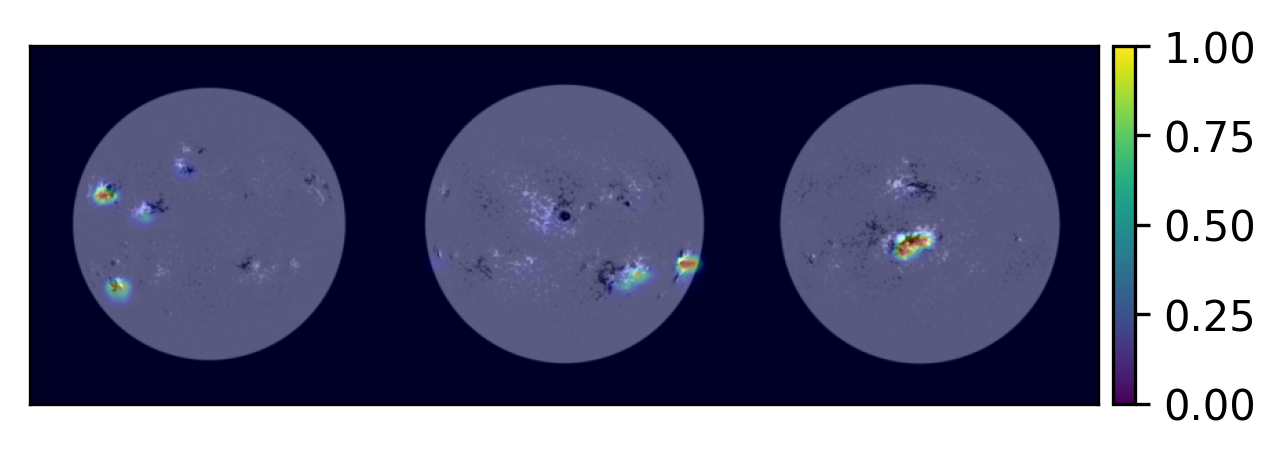

In [8]:
plot_attention(compute_attention(data_loader))